# 3. Modeling with an RNN

In this section, we will use the cleaned data to build a Recurrent Neural Network (RNN) model for classifying YouTube comments based on their toxicity.

### Key Steps:
- Load the cleaned data.  
- Split the data into training and test sets.  
- Address the class imbalance issue.  
- Build an RNN model.  
- Train the model.  

This process ensures a robust approach to creating a model capable of effectively identifying toxic comments.


Initially, we will retrieve the preprocessed data `cleaned_dataset.pickle` that we saved in the previous section : 

In [104]:
# Retrieving the preprocessed data:
import pickle

# Loading the preprocessed data and the tokenizer:
with open('../data/cleaned_dataset.pickle', 'rb') as f:
    data = pickle.load(f)

In [64]:
data.head()

,split,toxicity,toxicity_label,padded_sequences
0,train,0.373134,0,"[22, 178, 38, 120, 73, 22, 214, 8, 490, 2636, ..."
1,train,0.605263,1,"[1689, 434, 32, 1458, 196, 2, 110, 8, 751, 181..."
2,train,0.666667,1,"[5, 29, 1141, 38, 5412, 5478, 39, 15, 296, 17,..."
3,test,0.815789,1,"[177, 7558, 4, 160, 12, 6561, 2055, 30, 10, 1,..."
4,train,0.550000,1,"[17873, 5, 1089, 14, 227, 820, 192, 1506, 1, 0..."


In [65]:
print(data['toxicity_label'].value_counts())
print(f"Number of toxic comments: {data['toxicity_label'].value_counts()[1]}")

toxicity_label
0    435407
1    137164
Name: count, dtype: int64
Number of toxic comments: 137164


There are several methods to address the class imbalance problem, such as:
- Undersampling: reduce the size of the majority class.
- Class weights: assign more weight to the minority class.

We will combine both methods by using class weights and reducing the size of the majority class.

In [66]:
import pandas as pd

# We will reduce the size of the training data with label 0 by half to balance the data:

r = 2
data_0 = data[data['toxicity_label'] == 0].sample(n=data[data['toxicity_label'] == 1].shape[0] * r)
data_1 = data[data['toxicity_label'] == 1]

# Concatenating the two dataframes:
data = pd.concat([data_0, data_1])

In [67]:
print(f"Number of non-toxic comments in the training set: {data[(data['toxicity_label'] == 0) & (data['split'] == 'train')].shape[0]}")
print(f"Number of toxic comments in the training set: {data[(data['toxicity_label'] == 1) & (data['split'] == 'train')].shape[0]}")
print(f"Number of non-toxic comments in the test set: {data[(data['toxicity_label'] == 0) & (data['split'] == 'test')].shape[0]}")
print(f"Number of toxic comments in the test set: {data[(data['toxicity_label'] == 1) & (data['split'] == 'test')].shape[0]}")


Number of non-toxic comments in the training set: 247873
Number of toxic comments in the training set: 123882
Number of non-toxic comments in the test set: 26455
Number of toxic comments in the test set: 13282


In [68]:
import numpy as np

# Splitting the data into two sets: one for training and one for testing
dataset_train = data[data.split == 'train'].copy()
dataset_test = data[data.split == 'test'].copy()

# Dropping unnecessary columns
dataset_train.drop('split', axis=1, inplace=True)
dataset_test.drop('split', axis=1, inplace=True)

dataset_train.drop('toxicity', axis=1, inplace=True)
dataset_test.drop('toxicity', axis=1, inplace=True)

# Splitting the features and labels
y_train = np.array(dataset_train['toxicity_label'])
y_test = np.array(dataset_test['toxicity_label'])

X_train = np.array(dataset_train['padded_sequences'].tolist())
X_test = np.array(dataset_test['padded_sequences'].tolist())

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(371755, 100) (371755,) (39737, 100) (39737,)


In [69]:
# Only take 10% of the data for training randomly
proportion = 1  # Set to 1 for 100% of the data, adjust for different proportions
np.random.seed(42)  # Set seed for reproducibility

# Randomly sample the training data
train_indices = np.random.choice(X_train.shape[0], int(proportion * X_train.shape[0]), replace=False)
test_indices = np.random.choice(X_test.shape[0], int(proportion * X_test.shape[0]), replace=False)

# Apply the selected indices to the training data
X_train = X_train[train_indices]
y_train = y_train[train_indices]

# Keep an equal number of toxic and non-toxic comments in the test set by sampling randomly
toxic_indices = np.where(y_test == 1)[0]  # Indices of toxic comments
non_toxic_indices = np.where(y_test == 0)[0]  # Indices of non-toxic comments

# Combine the indices: all toxic comments and a random sample of non-toxic comments to match the number of toxic comments
test_indices = np.concatenate([toxic_indices, np.random.choice(non_toxic_indices, len(toxic_indices), replace=False)])

# Apply the selected indices to the test data
X_test = X_test[test_indices]
y_test = y_test[test_indices]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(371755, 100) (371755,) (26564, 100) (26564,)


In [70]:
# Count the number of 0 and 1 in the training set
class_0 = len(y_train[y_train == 0])
class_1 = len(y_train[y_train == 1])

print("Number of 0 in training set: ", class_0)
print("Number of 1 in training set: ", class_1)

# Count the number of 0 and 1 in the test set
print("Number of 0 in test set: ", len(y_test[y_test == 0]))
print("Number of 1 in test set: ", len(y_test[y_test == 1]))

Number of 0 in training set:  247873
Number of 1 in training set:  123882
Number of 0 in test set:  13282
Number of 1 in test set:  13282


## Building a Bidirectional LSTM Model for Toxic Comment Classification

In this section, we will define and construct a deep learning model using a Bidirectional LSTM (Long Short-Term Memory) network to classify text data into toxic and non-toxic categories. The model will be designed to process preprocessed text sequences, leveraging the power of embeddings and LSTM layers for effective sequence modeling. We will also employ dropout regularization to mitigate overfitting and use binary cross-entropy as the loss function since this is a binary classification task. Finally, we will summarize the model architecture for review.

### Model Architecture :
We employ a simple RNN architecture consisting of the following layers:

- Embedding: Converts words into dense vector representations.
- LSTM or GRU: Captures sequential dependencies in the text data.
- Dense: Classifies each comment as toxic or non-toxic.

This straightforward yet effective design is tailored for text classification tasks involving sequence data.


In [71]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall

# Defining the hyperparameters
vocab_size = 25000       # Maximum vocabulary size (number of unique words considered)
max_length = 100         # Maximum sequence length (post-padding/truncating)
embedding_dim = 128      # Dimensionality of the embedding vectors
lstm_units = 64          # Number of units in each LSTM layer
dropout_rate = 0.3       # Dropout rate for regularization
learning_rate = 0.001    # Learning rate for the optimizer

# Building the classification model
model = Sequential([
    # Embedding layer to transform indices into vectors
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
 
    # First bidirectional LSTM layer with sequence output
    Bidirectional(LSTM(lstm_units, return_sequences=False, activation='tanh', kernel_regularizer=l2(0.01))),
    Dropout(0.1),  # Regularization to avoid overfitting

    # Fully connected layer with ReLU activation
    Dense(64, activation='relu'),
    Dropout(0.2),
    
    Dense(32, activation='relu'),
    Dropout(0.3),

    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])

# Compiling the model
model.compile(
    loss='binary_crossentropy',             # Loss function for binary classification tasks
    optimizer=Adam(learning_rate=learning_rate),  # Adam optimizer with a defined learning rate
    metrics=['accuracy']                    # Metric used to evaluate performance
)

model.build(input_shape=(None, max_length))

# Display a summary of the model
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 100, 128)       │     3,200,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,309,185 (12.62 MB)

 Trainable params: 3,309,185 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

### Calculation of Weights for Imbalanced Classes

To calculate the weights to be used for imbalanced classes, we divide the total number of data points by the number of data points in each class to get the weights:

N = total number of data points,  
n_0 = number of samples in class 0,  
n_1 = number of samples in class 1

- w_0 = N / n_0  
- w_1 = N / n_1

To avoid the weights becoming too large or difficult to interpret, you can normalize the weights by dividing each weight by the sum of the weights.

In [72]:
N_total = len(y_train)
w_0 = N_total / class_0
w_1 = N_total / class_1

print("Weight for class 0: ", w_0/w_0)
print("Weight for class 1: ", w_1/w_0)

Weight for class 0:  1.0
Weight for class 1:  2.000879869553285


### Training the Model

In this section, we will train the model using the preprocessed training data. To address class imbalance, we will apply class weights, where toxic comments will be given more importance during training. We will also use a validation split of 20% of the data to monitor the model's performance on unseen data during training. Early stopping can be implemented to halt training if the validation performance doesn't improve. The model will run for a set number of epochs to optimize its parameters.

In [73]:
from tensorflow.keras.callbacks import EarlyStopping

class_weights = {0: 1, 1: 2}  # For example, giving more weight to toxic comments

history = model.fit(
    X_train, y_train,            # Input and output data
    epochs=5,                    # Number of iterations over the entire dataset
    batch_size=32,               # Number of samples used to estimate the gradient
    validation_split=0.2,        # 20% of the data used for validation
    verbose=1,                   # Displaying logs
    class_weight=class_weights,  # Weights for the classes
)



Epoch 1/5
9294/9294 ━━━━━━━━━━━━━━━━━━━━ 569s 61ms/step - accuracy: 0.6255 - loss: 0.9021 - val_accuracy: 0.8040 - val_loss: 0.4407
Epoch 2/5
9294/9294 ━━━━━━━━━━━━━━━━━━━━ 594s 64ms/step - accuracy: 0.8156 - loss: 0.5586 - val_accuracy: 0.8044 - val_loss: 0.4272
Epoch 3/5
9294/9294 ━━━━━━━━━━━━━━━━━━━━ 559s 60ms/step - accuracy: 0.8227 - loss: 0.5354 - val_accuracy: 0.8206 - val_loss: 0.4096
Epoch 4/5
9294/9294 ━━━━━━━━━━━━━━━━━━━━ 585s 63ms/step - accuracy: 0.8280 - loss: 0.5215 - val_accuracy: 0.8130 - val_loss: 0.4216
Epoch 5/5
9294/9294 ━━━━━━━━━━━━━━━━━━━━ 559s 60ms/step - accuracy: 0.8337 - loss: 0.5044 - val_accuracy: 0.7987 - val_loss: 0.4580


# 4. Evaluating the Model
### Main Steps:

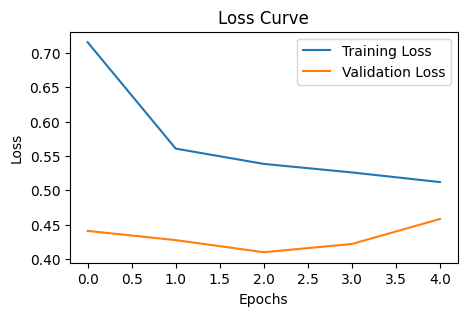

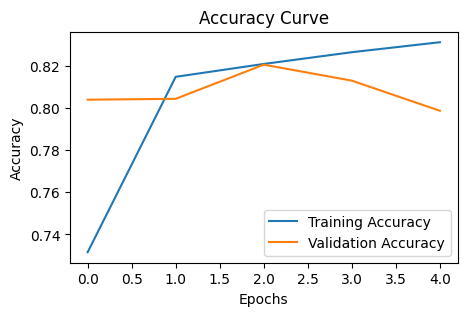

In [127]:
import matplotlib.pyplot as plt

# Loss curve
plt.figure(figsize=(5, 3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Accuracy curve
plt.figure(figsize=(5, 3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



From these graphs, we can observe that the training loss decreases and the training accuracy increases, indicating that the model is learning well on the training data. However, the validation loss and validation accuracy remain stable, showing no improvement and stagnating at 0.8 for accuracy. This suggests that the model has reached its maximum performance and is unlikely to improve further. Continuing training beyond this point risks overfitting.  

The fact that validation loss and validation accuracy do not improve from the very first epoch indicates that the model is sufficiently complex to capture simple patterns in the data but not complex enough to identify more intricate and subtle patterns that could enhance its performance.

In [128]:
# Model evaluation
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

831/831 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8627 - loss: 0.3183
Test Loss: 0.4306488037109375
Test Accuracy: 0.808914303779602


We notice that our model achieves an accuracy of 0.81 on the test data. However, accuracy is not an ideal metric for imbalanced classification problems. We will use the confusion matrix and classification report to better evaluate the model.

831/831 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step


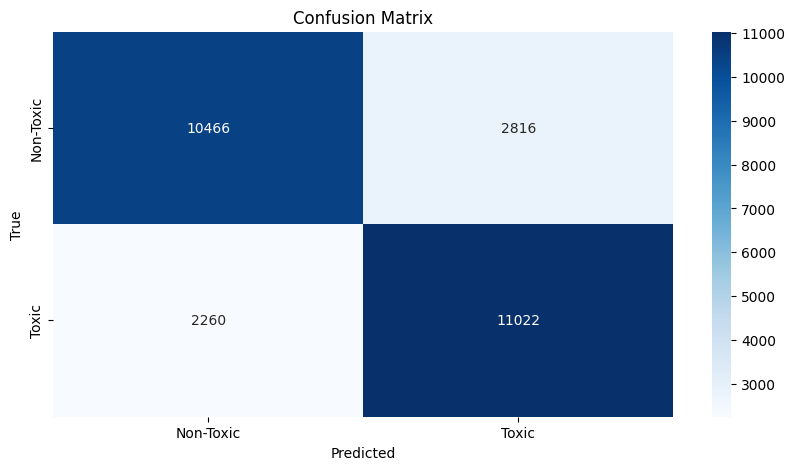

In [129]:
# Prediction on the test set with a confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Predicting probabilities for the test data
y_pred = model.predict(X_test)

# Generating the confusion matrix
# We compare the predicted values (thresholded at 0.5) with the actual labels (also thresholded)
cm = confusion_matrix(y_test > 0.5, y_pred > 0.5)

# Plotting the confusion matrix
plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

From this confusion matrix graph, we can see that the class imbalance issue has been resolved. The model is able to predict toxic and non-toxic comments with high precision and recall. This is further confirmed by the classification report below, which shows high precision, recall, and F1 scores for both classes.

#### Key Evaluation Metrics for Imbalanced Classification Problems

1. **Precision**  
   Precision is defined as the number of **correct predictions** (true positives) divided by the total number of predictions for a given class. However, for imbalanced classes, precision can still be high even if the model doesn't perform well on the minority class. This is why using tools like the **confusion matrix** and **classification report** is crucial for evaluating the model.

2. **Recall**  
   Recall is defined as the number of **true positives** divided by the sum of true positives and false negatives. This metric measures the model's ability to **identify all positive samples**, which is important when missing positive samples is costly.

3. **F1 Score**  
   The **F1 score** is the harmonic mean of precision and recall. It balances both metrics and is especially useful in imbalanced classification problems. The F1 score provides a single measure of model performance that accounts for both precision and recall, making it a more comprehensive evaluation metric.

4. **ROC-AUC**  
   **ROC-AUC** stands for *Receiver Operating Characteristic - Area Under the Curve*. It is a performance measurement for binary classification problems. The **ROC curve** plots the **True Positive Rate** (Recall) against the **False Positive Rate** (1 - Specificity) at various threshold settings.  
   - **AUC** (Area Under the Curve) is the area under this curve, with a value closer to 1 indicating better model performance, and a value near 0.5 suggesting the model is no better than random guessing.

5. **PR-AUC**  
   **PR-AUC** stands for *Precision-Recall Area Under the Curve*. It is similar to **ROC-AUC**, but it's particularly useful for **imbalanced datasets**. The **PR curve** plots **precision** against **recall**, and the **AUC** represents the area under this curve.  
   - A higher PR-AUC score indicates better model performance in identifying the positive class, especially when the negative class is much larger.


In [130]:
# Calculating precision, recall, and F1 score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test > 0.5, y_pred > 0.5)
recall = recall_score(y_test > 0.5, y_pred > 0.5)
f1 = f1_score(y_test > 0.5, y_pred > 0.5)

print(f"Precision: {precision}", f"Recall: {recall}", f"F1 Score: {f1}", sep='\n')

Precision: 0.7965023847376789
Recall: 0.8298449028760729
F1 Score: 0.8128318584070796


In [132]:
from sklearn.metrics import average_precision_score

# Calculating the PR-AUC score
pr_auc = average_precision_score(y_test, y_pred)

print(f"PR-AUC: {pr_auc}")


PR-AUC: 0.8981584694332273


A PR-AUC score of 0.9 means your model achieves a high precision across a range of recall values. 
This score shows your model is very effective at distinguishing between toxic and non-toxic comments, even in the presence of class imbalance.

## Model Conclusion

This model demonstrates reasonable but limited performance, with a precision of 0.8, a recall of 0.83, and an F1-score of 0.81. These metrics indicate that it correctly identifies a large proportion of positive examples while maintaining a good balance between precision and recall. However, the analysis of the loss and accuracy curves highlights significant limitations in its ability to generalize:

### 1. **Performance Observations**
   - **Training Data**: The model learns well on the training data, as evidenced by the decrease in loss and the increase in accuracy.
   - **Validation Data**: Validation metrics stagnate from the very first epoch, with accuracy plateauing at 0.8. This indicates that the model quickly reaches its limit in generalizing beyond the simple patterns present in the data.

### 2. **Limitations Analysis**
   - **Model Complexity**: The model appears to lack the capacity to capture more subtle or complex patterns in the data. This could be due to:
     - An architecture that is too simple or shallow, constrained by resource limitations.
     - Insufficient feature representation extracted by the model.
   - **Class Imbalance (Positive vs. Negative)**: Although the dataset is imbalanced, the model manages to maintain a reasonable F1-score. However, the imbalance may still affect the model's ability to generalize well to new data.

### 3. **Overfitting Risks**
   Since the model quickly reaches a plateau on validation data, continuing training risks overfitting on the training data without improving generalization.
   This is a clear signal that adjustments in model design or data preparation are needed to enhance performance.

### 4. **Recommendations for Improvement**
   - **Architecture Enhancement**:
     - Increase the depth or add more neurons in the layers to improve the learning capacity of the model.
   - **Data Augmentation**:
     - Expand the training dataset using data augmentation techniques or by collecting additional data.
     - Apply oversampling techniques to balance the classes.
   - **Hyperparameter Tuning**:
     - Experiment with different hyperparameters, such as activation functions, learning rates, and batch sizes, potentially using grid search to find the optimal configuration.
   - **Feature Engineering**:
     - Explore feature engineering techniques to enrich the input data and provide more informative signals to the model.

### 5. **General Conclusion**
The model is currently limited to moderate performance, primarily due to its insufficient complexity to capture subtle patterns in the data. While it avoids catastrophic errors and provides acceptable predictions, adjustments are needed to surpass this performance plateau and fully leverage the data's potential. However, the model is still adequate for use with simple and non-complex data, as we will see in the next steps.


In [131]:
# Save the model and its weights

import os
model_number = 0
for file in os.listdir('../src/model'):
    if file.startswith('toxicity_model'):
        model_number = max(model_number, int(file.split('_')[-1].split('.')[0]))

model.save('../src/model/toxicity_model_' + str(model_number + 1) + '.keras')


# 5. Inference on New Comments

Once the model has been trained, it’s time to test it on real-world examples to assess its ability to predict the toxicity of comments.  
We will also load the saved tokenizer to preprocess the text data before making predictions.

### Key Steps:
- Load the trained model and tokenizer.
- Preprocess new comments using the tokenizer and ```process_comment``` function used during preprocessing.
- Make predictions on the new comments using the trained model.

In [125]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

# global initialization of the WordNetLemmatizer
wordlem = WordNetLemmatizer()

# Function to process a comment
def process_comment(comment):
    # Convert to lowercase
    comment = comment.lower()

    # Delete HTML tags
    comment = re.sub(r'<.*?>', '', comment)
    
    # Keep only letters and spaces
    comment = re.sub(r'[^a-z\s]', '', comment)

    # Delete multiple spaces
    comment = re.sub(r'\s+', ' ', comment).strip()

    # Tokenization
    tokens = word_tokenize(comment)

    # Lemmatization
    final_tokens = [wordlem.lemmatize(w) for w in tokens]

    return ' '.join(final_tokens)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\helle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\helle\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\helle\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [134]:
from keras.models import load_model

# Load the saved tokenizer
with open('../src/tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

model = load_model('../src/model/toxicity_model_0.keras')

# Preprocessing and tokenization function
def preprocess_text(text, tokenizer, max_length):
    # Cleaning (as before)
    text_cleaned = process_comment(text)
    # Convert to numerical sequence
    sequence = tokenizer.texts_to_sequences([text_cleaned])
    # Apply padding
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')
    return padded_sequence

# Example of new comments
new_comments = [
    "I love this video, it was very helpful!",
    "This is the worst content I've ever seen. Total garbage!",
    "You should die, you idiot.",
    "I am the best president ever"
]

# Predictions
for comment in new_comments:
    preprocessed_comment = preprocess_text(comment, tokenizer, max_length)
    prediction = model.predict(preprocessed_comment)[0][0]
    toxicity = "Toxic" if prediction > 0.5 else "Non-Toxic"
    print(f"Comment: {comment}")
    print(f"Predicted Toxicity: {toxicity} (Score: {prediction:.2f})\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
Comment: I love this video, it was very helpful!
Predicted Toxicity: Non-Toxic (Score: 0.18)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Comment: This is the worst content I've ever seen. Total garbage!
Predicted Toxicity: Toxic (Score: 0.98)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
Comment: You should die, you idiot.
Predicted Toxicity: Toxic (Score: 1.00)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Comment: I am the best president ever
Predicted Toxicity: Non-Toxic (Score: 0.29)



Overall, the model is effectively distinguishing between toxic and non-toxic comments, even when faced with a range of expressions. Its high accuracy on toxic content, coupled with appropriate responses to non-toxic comments, shows it is well-trained to handle different types of input. However, further fine-tuning could be considered to ensure more nuanced edge cases are properly classified.